# Bottleneck distance visualisation of PA congressional plan

## Preliminary Steps

Import some packages.

In [2]:
import geopandas as gpd

import random

import matplotlib.pyplot as plt
from functools import partial
import networkx as nx

from gerrychain import MarkovChain
from gerrychain.constraints import (
    Validator,
    single_flip_contiguous,
    within_percent_of_ideal_population,
)
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import Election, Tally, cut_edges
from gerrychain.partition import Partition
from gerrychain.proposals import recom
from gerrychain.metrics import mean_median, efficiency_gap

import csv
import os
from functools import partial
import json

import matplotlib.pyplot as plt

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.tree import recursive_tree_part

Define functions to create district adjacency graphs.

In [3]:
def district_pairs(part):
    pairs = []
    for x, y in part['cut_edges']:
        pairs.append((part.assignment[x],part.assignment[y]))
    return set(pairs)

def adjacency_graph_cut_edges(part):
    edges = district_pairs(part)
    adjacency_graph = nx.Graph()
    adjacency_graph.add_nodes_from(list({x for (x,y) in edges}))
    adjacency_graph.add_edges_from(list(edges))
    return adjacency_graph

Import some data.

In [4]:
pop_col = "TOT_POP"
election_names = [
    "PRES12",
    "PRES16",
    "SENW101216",
]
election_columns = [
    ["PRES12D", "PRES12R"],
    ["T16PRESD", "T16PRESR"],
    ["W101216D", "W101216R"],
]
graph = Graph.from_file("./PA_VTD/PA_VTD.shp")
gdf = gpd.read_file("./PA_VTD/PA_VTD.shp")

Define updaters.

In [5]:
updaters1 = {
    "population": updaters.Tally("TOT_POP", alias="population"),
    "cut_edges": cut_edges,
}

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(len(election_names))
]

election_updaters = {election.name: election for election in elections}

updaters1.update(election_updaters)

## Get some "real" plans

We will look at some 'premade' partitions. In particular, `partition_2011` is the real districting plan from 2011.

In [6]:
print("Sample node: ", graph.nodes[0])
#fix some strings which should be numbers
for n in graph.nodes():
    graph.nodes[n]['538CPCT__1'] = int(graph.nodes[n]['538CPCT__1'])
    graph.nodes[n]['538DEM_PL'] = int(graph.nodes[n]['538DEM_PL'])
    graph.nodes[n]['538GOP_PL'] = int(graph.nodes[n]['538GOP_PL'])
    graph.nodes[n]['8THGRADE_1'] = int(graph.nodes[n]['8THGRADE_1'])
    

Sample node:  {'boundary_node': False, 'area': 58376433.4607846, 'STATEFP10': '42', 'COUNTYFP10': '039', 'VTDST10': '60', 'GEOID10': '42039060', 'VTDI10': 'A', 'NAME10': 'CAMBRIDGE SPRINGS Voting District', 'NAMELSAD10': 'CAMBRIDGE SPRINGS Voting District', 'LSAD10': '00', 'MTFCC10': 'G5240', 'FUNCSTAT10': 'N', 'ALAND10': 2258229, 'AWATER10': 0, 'INTPTLAT10': '+41.8018353', 'INTPTLON10': '-080.0596566', 'ATG12D': 0.0, 'ATG12R': 0.0, 'GOV10D': 0.0, 'GOV10R': 0.0, 'PRES12D': 0.0, 'PRES12O': 0.0, 'PRES12R': 0.0, 'SEN10D': 0.0, 'SEN10R': 0.0, 'T16ATGD': 0.0, 'T16ATGR': 0.0, 'T16PRESD': 0.0, 'T16PRESOTH': 0.0, 'T16PRESR': 0.0, 'T16SEND': 0.0, 'T16SENR': 0.0, 'USS12D': 0.0, 'USS12R': 0.0, 'GOV': 3, 'TS': 5, 'HISP_POP': 0, 'TOT_POP': 0, 'WHITE_POP': 0, 'BLACK_POP': 0, 'NATIVE_POP': 0, 'ASIAN_POP': 0, 'F2014GOVD': 0, 'F2014GOVR': 0, '2011_PLA_1': 3, 'REMEDIAL_P': 14, '538CPCT__1': '03', '538DEM_PL': '03', '538GOP_PL': '03', '8THGRADE_1': '1', 'geometry': <shapely.geometry.polygon.Polygon objec

In [7]:
partition_2011 = Partition(graph, "2011_PLA_1", updaters1)
partition_GOV = Partition(graph, "GOV", updaters1)
partition_TS = Partition(graph, "TS", updaters1)
partition_REMEDIAL = Partition(graph, "REMEDIAL_P", updaters1)
partition_CPCT = Partition(graph, "538CPCT__1", updaters1)
partition_DEM = Partition(graph, "538DEM_PL", updaters1)
partition_GOP = Partition(graph, "538GOP_PL", updaters1)
partition_8th = Partition(graph, "8THGRADE_1", updaters1)

In [8]:
ideal_population = sum(partition_2011["population"].values())/len(partition_2011)
print("Ideal popuation: ", ideal_population)

Ideal popuation:  704718.2777777778


## Create tree plans and add them to the list

In [9]:
tree_partitions = []

tree_plans = 10 #set this higher later...

for i in range(tree_plans):
    print('Finished tree plan', i)
    cddict = recursive_tree_part(graph, range(18), ideal_population, "TOT_POP", .01, 2)
    tree_partitions.append(Partition(graph, cddict, updaters1))

Finished tree plan 0
Finished tree plan 1
Finished tree plan 2
Finished tree plan 3
Finished tree plan 4
Finished tree plan 5
Finished tree plan 6
Finished tree plan 7
Finished tree plan 8
Finished tree plan 9


In [10]:
partition_list = [partition_2011, partition_GOV, partition_TS,
                  partition_REMEDIAL, partition_CPCT, partition_DEM,
                  partition_GOP, partition_8th]

In [11]:
labels = ['2011', 'GOV', 'TS', 'REMEDIAL', 'CPCT', 'DEM', 'GOP', '8th']+["Tree" + str(k + 1) for k in range(tree_plans)];

In [12]:
print(labels)
print(len(labels))

['2011', 'GOV', 'TS', 'REMEDIAL', 'CPCT', 'DEM', 'GOP', '8th', 'Tree1', 'Tree2', 'Tree3', 'Tree4', 'Tree5', 'Tree6', 'Tree7', 'Tree8', 'Tree9', 'Tree10']
18


In [13]:
full_partition_list = partition_list + tree_partitions

In [14]:
num_partitions = len(full_partition_list)
print(num_partitions)

18


## Computing Adjacency Graphs and Barcodes

In [15]:
import gudhi as gd
import numpy as np
import operator

In [16]:
def relabel_by_dem_vote_share(part):
    unranked_to_ranked = sorted(
        [(list(part.parts.keys())[x],part['PRES12'].percents('Democratic')[x]) for x in range(0, len(part))], key=operator.itemgetter(1))
    unranked_to_ranked_list = [x[0] for x in unranked_to_ranked]
    unranked_to_ranked = {unranked_to_ranked[x][0]:x+1 for x in range(0, len(part))}
    newpart = Partition(graph, {x:unranked_to_ranked[part.assignment[x]] for x in graph.nodes}, updaters1)
    return newpart

/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical left == right == 0.360563113997135 results in singular transformations; automatically expanding.
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical bottom == top == 0.360563113997135 results in singular transformations; automatically expanding.


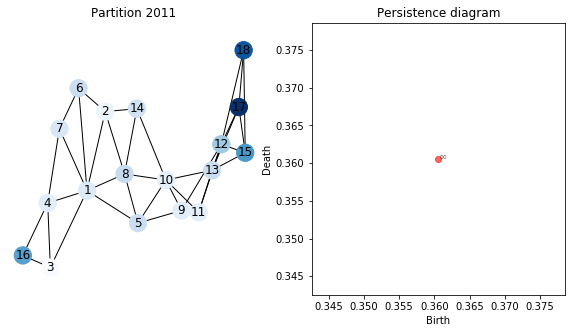

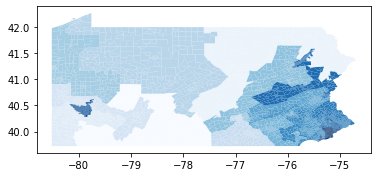

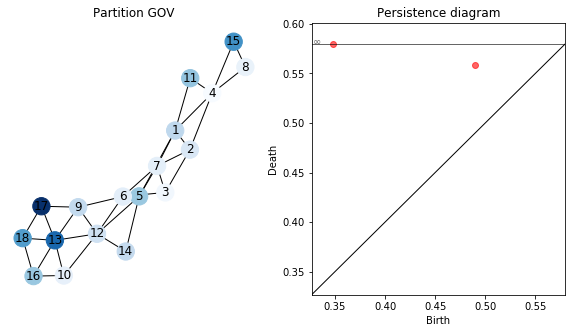

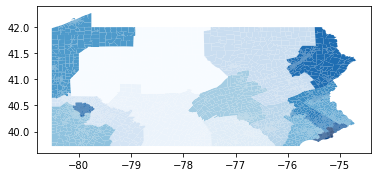

/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical left == right == 0.35136273826127384 results in singular transformations; automatically expanding.
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical bottom == top == 0.35136273826127384 results in singular transformations; automatically expanding.


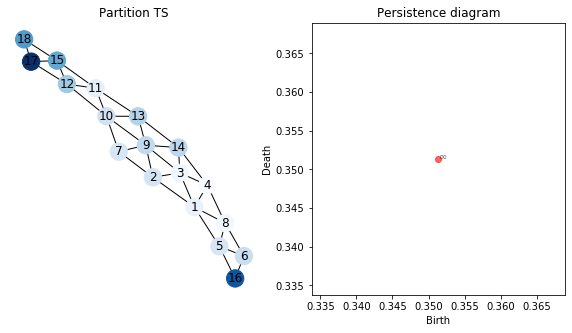

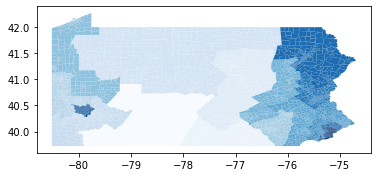

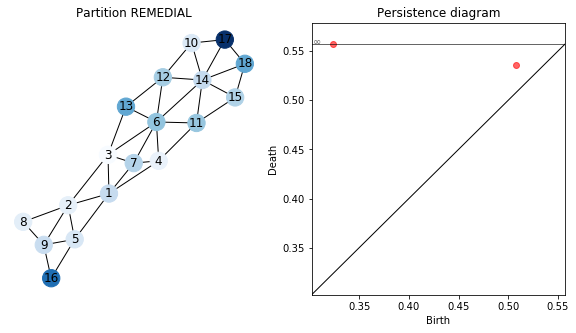

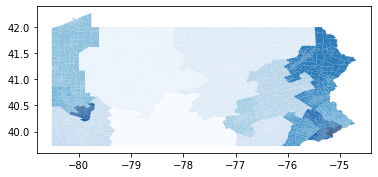

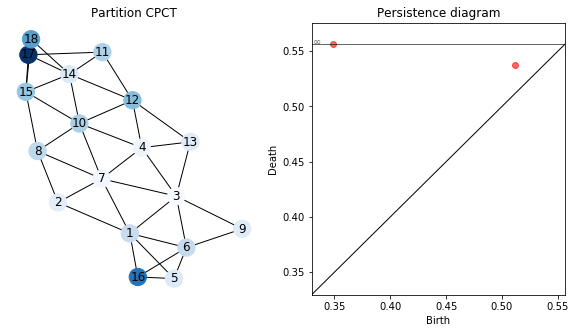

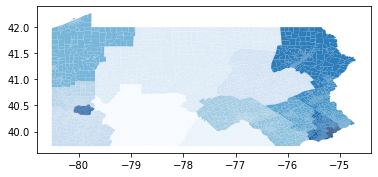

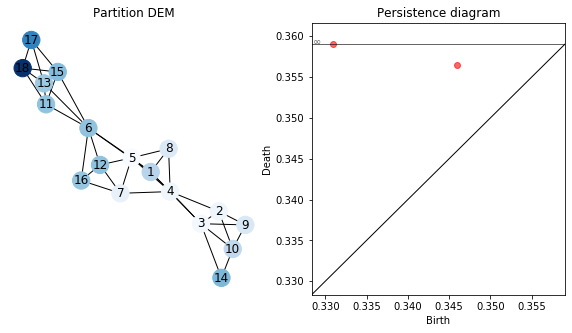

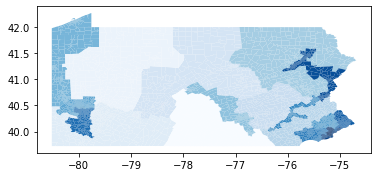

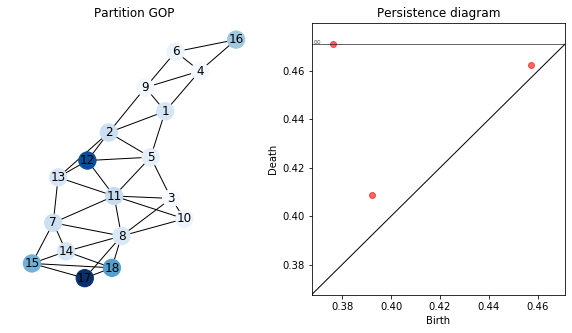

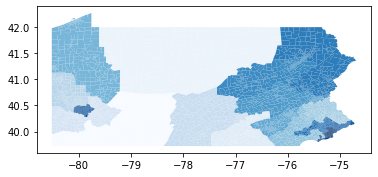

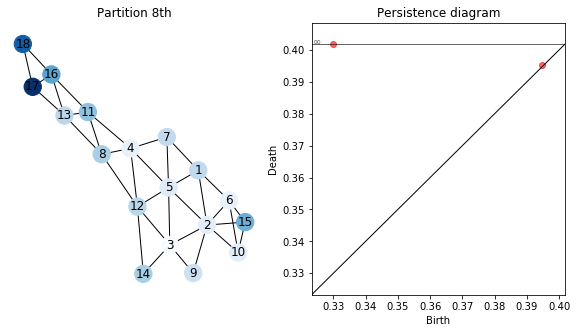

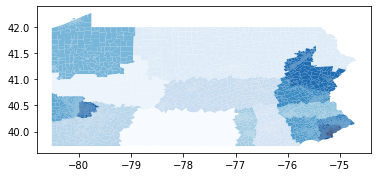

/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical left == right == 0.37056107173666675 results in singular transformations; automatically expanding.
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical bottom == top == 0.37056107173666675 results in singular transformations; automatically expanding.


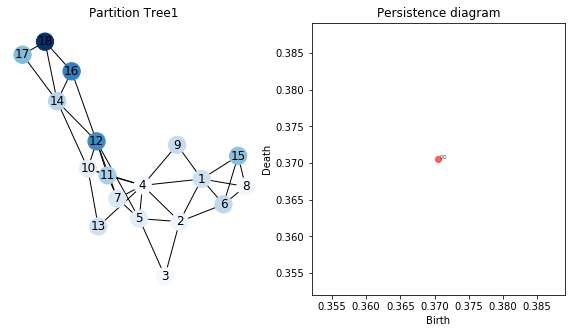

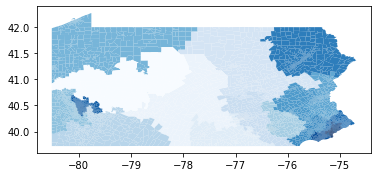

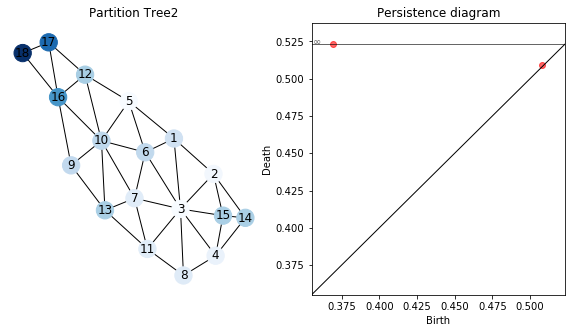

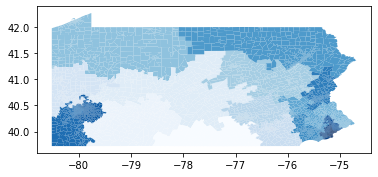

/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical left == right == 0.31229632737867624 results in singular transformations; automatically expanding.
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical bottom == top == 0.31229632737867624 results in singular transformations; automatically expanding.


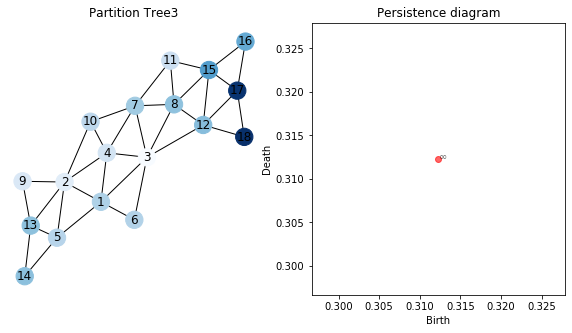

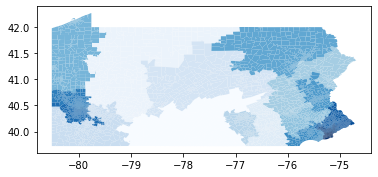

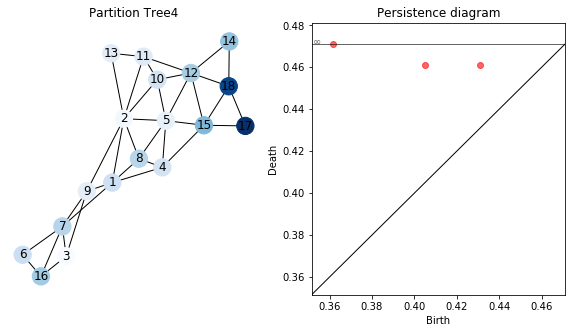

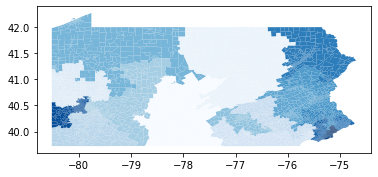

/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical left == right == 0.3310819235304386 results in singular transformations; automatically expanding.
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical bottom == top == 0.3310819235304386 results in singular transformations; automatically expanding.


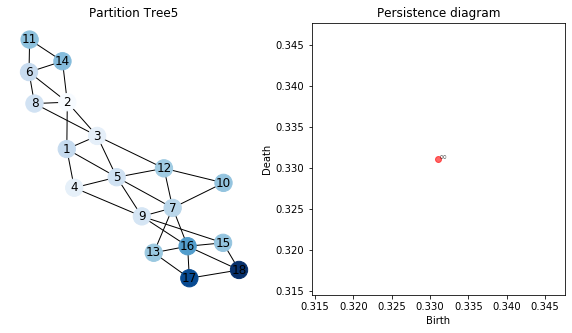

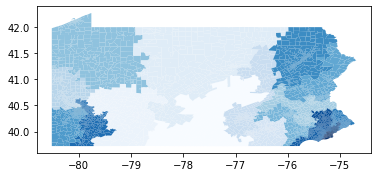

/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical left == right == 0.32834458779521275 results in singular transformations; automatically expanding.
/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Attempting to set identical bottom == top == 0.32834458779521275 results in singular transformations; automatically expanding.


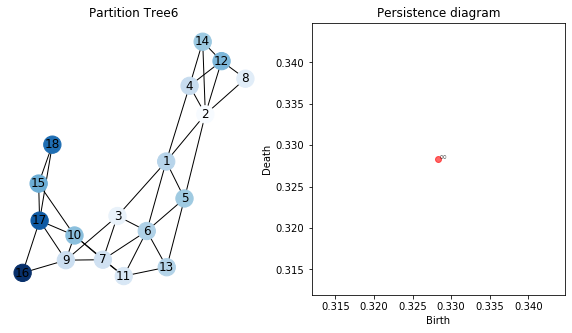

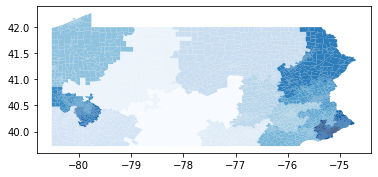

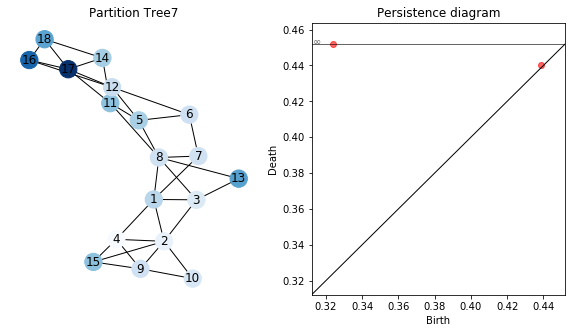

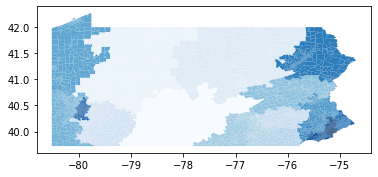

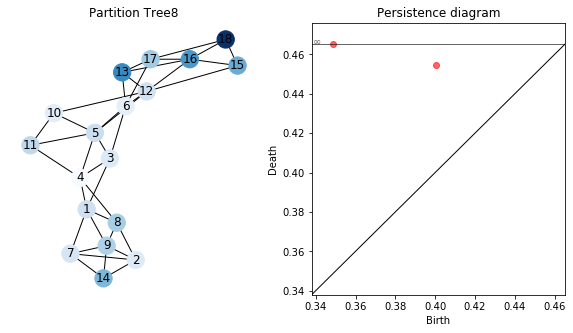

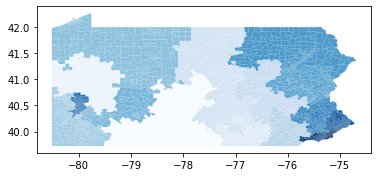

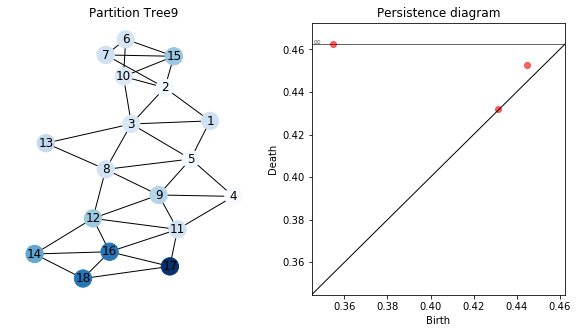

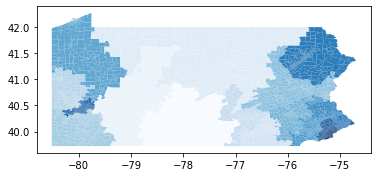

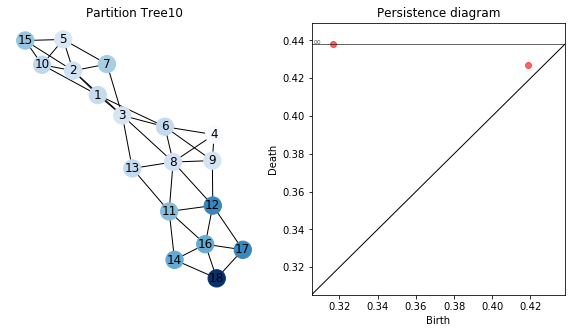

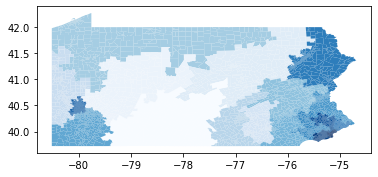

In [17]:
partitions_spCpx = []

for k in range(num_partitions):
    part = relabel_by_dem_vote_share(full_partition_list[k])    

    adjacency_graph = adjacency_graph_cut_edges(part)

    spCpx = gd.SimplexTree()

    for edge in adjacency_graph.edges:
        spCpx.insert(list(edge))

    Democratic_voter_share = part['PRES12'].percents('Democratic')

    zero_skeleton = spCpx.get_skeleton(0)
    #print(zero_skeleton)

    for j in range(len(zero_skeleton)):
        spCpx.assign_filtration(zero_skeleton[j][0], filtration=sorted(Democratic_voter_share)[j])

    spCpx.make_filtration_non_decreasing()

    BarCodes = spCpx.persistence()

    fig = plt.figure(figsize = (10,5))

    ax = fig.add_subplot(1,2,1)
    nx.draw_networkx(adjacency_graph, node_color=Democratic_voter_share, cmap=plt.cm.Blues)
    plt.title('Partition '+labels[k])
    ax.axis('off')

    fig.add_subplot(1,2,2)
    gd.plot_persistence_diagram(BarCodes)
    part.plot(gdf, cmap=plt.cm.Blues)
    plt.show()
    partitions_spCpx.append(spCpx)

## Bottleneck Distances

Now we can create a distance matrix containing the bottleneck distance between any pair of barcodes.

In [18]:
distMat = np.zeros((num_partitions,num_partitions))

for j in range(num_partitions):
    for k in range(num_partitions):
        spCpx0 = partitions_spCpx[j]
        spCpx1 = partitions_spCpx[k]
        
        spCpx0.persistence()
        spCpx1.persistence()

        I0 = spCpx0.persistence_intervals_in_dimension(0)
        I1 = spCpx1.persistence_intervals_in_dimension(0)

        distMat[j,k] = gd.bottleneck_distance(I0,I1)
        
# Symmetrize to remove any numerical errors

In [19]:
distMat = np.maximum(distMat, distMat.T)

We view the distance matrix as an image.

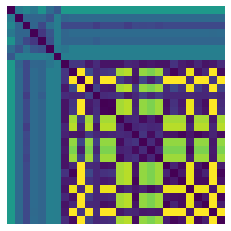

In [22]:
plt.imshow(distMat);
plt.axis('off');

To understand the shape of the 'space of districting plans', we can use Multi-Dimensional Scaling. This algorithm looks for the set of points in $\mathbb{R}^2$ (or $\mathbb{R}^3$) whose distance matrix is as close as possible to the distance matrix we just computed. For a more precise description, go here: https://en.wikipedia.org/wiki/Multidimensional_scaling

The result gives us a visualization of how similar the districting plans are.

In [23]:
colors = len(partition_list)*['r'] + len(tree_partitions)*['b']

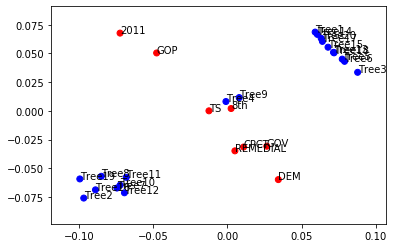

In [24]:
# Import a package containing the MDS algorithm and set options for the algorithm
from sklearn import manifold
mds = manifold.MDS(n_components=2, dissimilarity="precomputed")

# Compute MDS and extract the coordinates of the points
results = mds.fit(distMat)
coords = results.embedding_

z = coords[:,0]
y = coords[:,1]

fig, ax = plt.subplots()
ax.scatter(z, y, c = colors)

for i, txt in enumerate(labels):
    ax.annotate(txt, (z[i], y[i]))

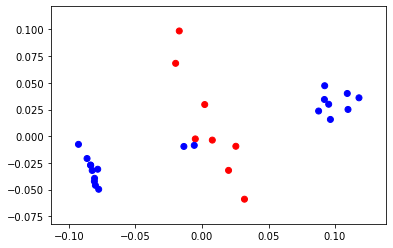

In [25]:
# Import a package containing the MDS algorithm and set options for the algorithm
from sklearn import manifold
mds = manifold.MDS(n_components=2, dissimilarity="precomputed")

# Compute MDS and extract the coordinates of the points
results = mds.fit(distMat)
coords = results.embedding_

z = coords[:,0]
y = coords[:,1]

fig, ax = plt.subplots()
ax.scatter(z, y, c = colors)

We can also use MDS to project the data to 3D. It takes a little more work to make the plot. You can try running this a few times; MDS doesn't have a unique answer and the algorithm involves some randomness, so you will get something different every time you run it.

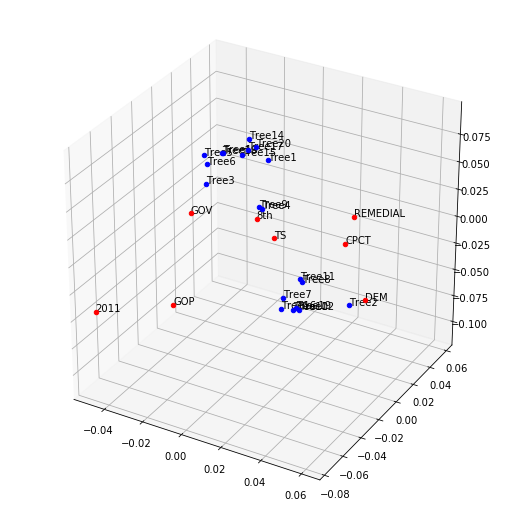

In [26]:
from mpl_toolkits.mplot3d import Axes3D

mds = manifold.MDS(n_components=3, dissimilarity="precomputed")
results = mds.fit(distMat)
coords = results.embedding_

fig = plt.figure(figsize = (7,7))
ax = Axes3D(fig)

for i, txt in enumerate(labels):
    ax.scatter(coords[i,0],coords[i,1],coords[i,2], c = colors[i]) 
    ax.text(coords[i,0],coords[i,1],coords[i,2],  '%s' % (txt), size=10, zorder=1) 


plt.show()

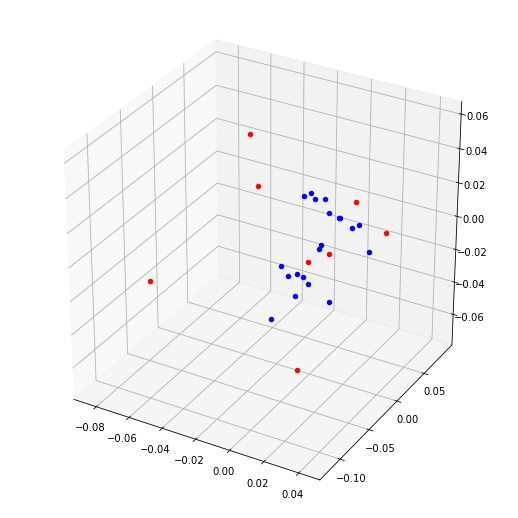

<Figure size 432x288 with 0 Axes>

In [27]:
from mpl_toolkits.mplot3d import Axes3D

mds = manifold.MDS(n_components=3, dissimilarity="precomputed")
results = mds.fit(distMat)
coords = results.embedding_

fig = plt.figure(figsize = (7,7))
ax = Axes3D(fig)

for i, txt in enumerate(labels):
    ax.scatter(coords[i,0],coords[i,1],coords[i,2], c = colors[i]) 


plt.show()
plt.savefig('PennsylvaniaRecomExperiment.png')

/Users/thomasweighill/miniconda3/envs/Gerry/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


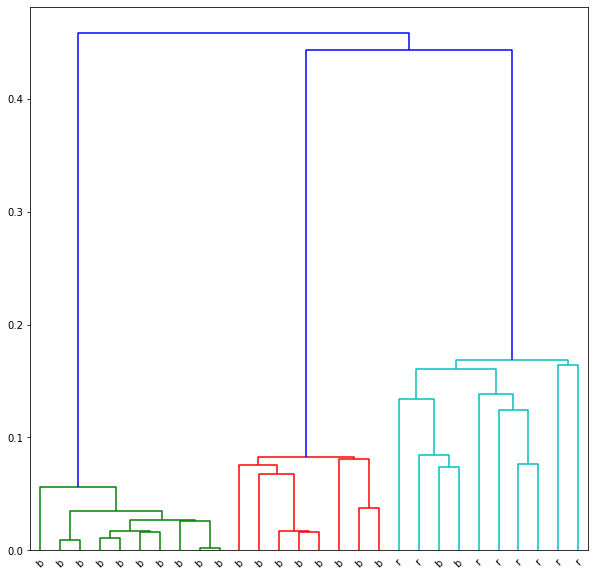

In [28]:
from scipy.cluster import hierarchy

linkage = hierarchy.linkage(distMat, 'single')


plt.figure(figsize = (10,10))
hierarchy.dendrogram(linkage, labels = colors);